In [1]:
import spacy
import string

def clean_text(corpus):
    # Remove punctuations from the corpus
    translator = str.maketrans('', '', string.punctuation)
    corpus = corpus.translate(translator)

    # Remove digits from the corpus
    remove_digits = str.maketrans('', '', string.digits)
    corpus = corpus.translate(remove_digits)
    return corpus



with open("scripts_concat.txt", "r") as f:
    scripts_string = f.read()

corpus = clean_text(scripts_string)

nlp = spacy.load('en_core_web_sm')


print("Tamaño del corpus: {}".format(len(corpus)))
print("nlp max length: {}".format(nlp.max_length))

corpus_chunk = [corpus[i:i+nlp.max_length] for i in range (0,len(corpus), nlp.max_length)]


# we process chunks of the corpus accoding to the max length of nlp

docs = []
for chunk in corpus_chunk:
    doc = nlp(chunk)
    docs.append(doc)



Tamaño del corpus: 4740654
nlp max length: 1000000


# Análisis del texto

In [2]:
words = []
nouns = []
verbs = []
people = []
orgs = []


for doc in docs:
    for token in doc:
        words.append(token.text)
        if token.pos_ == "VERB":
            verbs.append(token.text)
            
        if token.pos_ == "NOUN":
            nouns.append(token.text)


for doc in docs:
    for ent in doc.ents:
        if ent.label_ == "ORG":
            orgs.append(ent.text)
        if ent.label_ == "PERSON":
            people.append(ent.text)

print("Total words: ", len(words))
print("Total verbs: ", len(verbs))
print("Total nouns: ", len(nouns))
print("Total people: ", len(people))
print("Total organizations: ", len(orgs))

Total words:  656598
Total verbs:  88254
Total nouns:  85804
Total people:  17500
Total organizations:  6215


## Contando palabras

In [3]:
from collections import Counter
from collections import OrderedDict

def sort_by_frequency(data,reverse=True):
    """ 
    Function to sord the data by its frequency
    Returns ordered dictionary
    Default: Sort in descending order
        
    """
    data_with_freq = dict(Counter(data))
    data_sorted_by_freq = OrderedDict(sorted(data_with_freq.items(), key=lambda x: x[1],reverse=reverse))
    
    return data_sorted_by_freq

words_frequency = sort_by_frequency(words)
nouns_frequency = sort_by_frequency(nouns)
verbs_frequency  = sort_by_frequency(verbs)
people_frequency = sort_by_frequency(people)
orgs_frequency = sort_by_frequency(orgs)

#print(verbs_frequency)

# Analizando Bigramas

In [4]:
import nltk

def create_bigram(tokens):
    # Using words token generated from spacy to find bigram
    bigrams_ = list(nltk.bigrams(tokens))
    # Convert generator into list of tuples of bigram 
    bigrams = [" ".join(bigram) for bigram in list(bigrams_)]

    return bigrams

bigrams = create_bigram(words)

def check_racial_slur_in_bigrams(bigrams):
    with open("racist_slang.txt", "r") as f:
        racist_slang_list = f.read().split("\n")
    
    racist_bigrams = []
    for bigram in bigrams:
        if any(word in bigram for word in racist_slang_list):
            racist_bigrams.append(bigram)
    
    return racist_bigrams



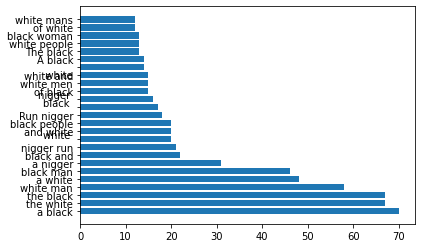

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def get_top_n_from_order_dict(ordered_dict,n):
    """ Function to find n top object from ordered dictionary"""
    return [list(ordered_dict.items())[i] for i in range(n)]


def visualize_list_of_tuple(data):
    """"""
    list1, list2 = zip(*data)
    y_pos = np.arange(len(list1))
    plt.barh(y_pos, list2, align='center' )
    plt.yticks(y_pos, list1)
    plt.show()

top_racist_bigrams = get_top_n_from_order_dict(sort_by_frequency(check_racial_slur_in_bigrams(bigrams)) , 25)
# The most popular rascist slurs
visualize_list_of_tuple(top_racist_bigrams)

# Clustering

## Clustering con monogramas

In [12]:
import spacy
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter



NUM_CLUSTERS = 10

# funcion para normalizar el oraciones


def normalize_sentence(span):
    # sacamos stopwords y signos de puntuación
    words = [t for t in span if not t.is_punct | t.is_stop]
    # nos quedamos con tokens alfabéticos y con largo considerable
    lexical_tokens = [t for t in words if len(t.orth_) > 3 and
                      t.orth_.isalpha()]

    # removemos pronombres
    cleaned_lemmas = [tok.lemma_.lower()
                      for tok in lexical_tokens if tok.pos_ != 'PRON']

    return cleaned_lemmas


def show_results(vocabulary, model):
    # Show results
    c = Counter(sorted(model.labels_))
    print("\nTotal clusters:", len(c))
    for cluster in c:
        print("Cluster#", cluster, " - Total words:", c[cluster])

    # Show top terms and words per cluster
    print("Top words per cluster:")
    print()

    keysVocab = list(vocabulary.keys())
    for n in range(len(c)):
        print("Cluster %d" % n)
        print("Words:", end='')
        word_indexs = [i for i, x in enumerate(list(model.labels_)) if x == n]
        for i in word_indexs:
            print(' %s' % keysVocab[i], end=',')
        print()
        print()

    print()



lemmatized_sentences = []

for doc in docs:
    for span in doc.sents:
        lemmatized_sentences.append(normalize_sentence(span))


# entrenamos un modelo de word embeddings neuronales
model = Word2Vec(lemmatized_sentences, min_count=1)
vocabulary = model.wv.key_to_index

# vectores que conseguimos del modelo
vectors = []
for word in vocabulary:
    vectors.append(model.wv[word])

matrix = np.array(vectors)
print("Matrix shape:", matrix.shape)

# normalizamos matriz y reducimos dimensionalidad quitando columnas con poca varianza

matrix_normed = matrix / matrix.max(axis=0)

variances = np.square(matrix_normed).mean(axis=0) - \
    np.square(matrix_normed.mean(axis=0))
VarianzaMin = 0.001
red_matrix = np.delete(matrix_normed, np.where(
    variances < VarianzaMin), axis=1)


# Utilizamos el algoritmo de K-means de scikit-learn
k_means_model = KMeans(n_clusters=NUM_CLUSTERS, init = "k-means++",max_iter=150,n_init=1)
k_means_model.fit(red_matrix)


#show_results(vocabulary, k_means_model)

Matrix shape: (18771, 100)


KMeans(max_iter=150, n_clusters=10, n_init=1)

## Clustering sobre scripts completos

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import time
from sklearn.cluster import KMeans




class DocumentCluster:
    """Class to cluster document"""
    def __init__(self,model,data,labels):
        self.model = model
        self.data = data
        self.labels = labels
        self.model_name = self._get_model_name()
        
        self.cluster_pipeline = None
        
    
    def _get_model_name(self):
        """Get name of model being used"""
        model_name = str(self.model).split('(')[0]
        return model_name
            

    
    def train_model(self,ngram,use_idf):
        """ 
            Train model
            ngram: int
            use_idf: bool
            analyzer: string
        
        """
        current_time = time.time()
        self._ngram = ngram
        self._use_idf = use_idf
        
        # Set a pipeline
        # 1. The first step of the pipeline is to find count vectorizer
        # Countvectorizer converts a collection of text documents to a matrix of token counts
        # This implementation produces a sparse representation of the counts
        # 2. We then use TfidfTransformr
        # TfidfTransformer transforms a count matrix to a normalized tf or tf-idf representation
        # Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency

        self.cluster_pipeline = Pipeline([('vect', CountVectorizer(ngram_range=(1,ngram), 
                analyzer="word")), ('tfidf', TfidfTransformer(use_idf=use_idf)), 
                ('model', self.model)])
        self._cluster = self.cluster_pipeline.fit(self.data)
        
        self._train_time = time.time() - current_time
        
        
        print("Training completed")
        print("Training time for {} : {} secs".format(self.model_name, self._train_time))
        
    
    def predict(self):
        """
        Predict cluster id for all clusters
        """
        self.label_id_dict = {}
        self.document_id_dict = {}
        self.cluster_id = []
        for i, document in enumerate(self.data):
            cluster_id = self.cluster_pipeline.predict([document])[0]
            self.label_id_dict.update({self.labels[i]:cluster_id})
            self.document_id_dict.update({document:cluster_id})
            self.cluster_id.append(cluster_id)
        
        return self.label_id_dict, self.document_id_dict

In [20]:
import json

with open("movies_scripts.json", "r") as f:
    data = json.load(f)

docs = list(map(lambda d: d["script"], data.values()))
labels = list(data.keys()) # the labels of each doc it's the name of the movie

cleaned_docs = []
for d in docs:
    cleaned_docs.append(clean_text(d).lower())


In [24]:
cluster_num = 5
model = KMeans(n_clusters=cluster_num, init = "k-means++",max_iter=150,n_init=1)

doc_cluster = DocumentCluster(data=cleaned_docs,model=model,labels=labels)

doc_cluster.train_model(ngram=2, use_idf=True)

result_label, result_docs = doc_cluster.predict()


result_label

Training completed
Training time for KMeans : 1.852720022201538 secs


{'gran torino': 4,
 'american history x': 4,
 'blackkklansman': 3,
 'School ties': 4,
 'race': 4,
 '42': 2,
 'django': 4,
 'red tails': 2,
 'the green mile': 4,
 'white chicks': 4,
 'glory road': 4,
 'ali': 4,
 'a time to kill': 2,
 'malcolm x': 4,
 'finding forrester': 1,
 'black cop': 2,
 'get out': 4,
 'Do the Right Thing': 4,
 'Fruitvale Station': 0,
 '12 Years a Slave': 4,
 'Born on the Fourth of July': 4,
 'forrest gump': 4,
 'Gangs of New York Script': 4}